## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 10 - Tree Models**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [6]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
n_signal = len(all_signal_list)
signal_list = [signal+".4096" for signal in all_signal_list]

可以尝试的树模型：
- 梯度提升树 Gradient Boosting Decision Tree (Classification/Regression)
- AdaBoost
- XGBoost
- LightGBM

需要注意，数据竞赛万金油的xgboost和lightgbm是支持gpu加速的，但是sklearn的初始设置并不支持gpu，是早期设计的问题，因为sklearn是为了研究设计的，不是为了部署设计的，而大批量的机器学习部署都会用到显卡，用到gpu，基本使用的都是支持gpu的树模型，或者基于cuDNN和CUDA开发的pytorch和tensorflow。也就是企业部署大规模机器学习的时候是不会用到sklearn的。

因此，sklearn不支持gpu，那我们就只能使用cpu并行。但同样需要注意，那就是尽管我们在DecisionTreeClassifier()可以使用n_jobs参数，包括ensemble learning的BaggingClassifier()以及随机森林RandomForestClassifier()，但是对于GBDT，也就是GradientBoostingRegressor()或者GradientBoostingClassifier()是不能并行的，这个就不解释了，随机森林显然可以并行，但GBDT只能串行，因此参数里面没有n_jobs，鼠标看就能发现。因此我们只能让他串行，然后最多在GridSearchCV()中使用n_jobs，此时代表的是并行去运行cross validation，而不是并行运行模型了。

In [7]:
# https://github.com/Laurae2/lgbdl
# https://github.com/r-dbi/RPostgres/issues/110

In [8]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

In [9]:
import xgboost as xgb
import lightgbm as lgb
import os

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [11]:
ori_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [12]:
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")

print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (4809, 48)
hc (4208, 48)
i (4393, 48)
j (3639, 48)
jm (3403, 48)


In [13]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list:
    cur_train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [14]:
print(train_mat.shape)
print(test_mat.shape)

(20452, 48)
(21169, 48)


In [15]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values

In [66]:
# Model 1: Gradient Boosting Regressor
strat = "gbm.002.4096"
for product in product_list:
    os.makedirs(HEAD_PATH +"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

# 如之前所说，GBDT只能串行
gb1 = GradientBoostingRegressor(random_state=0)

# 面板搜索的参数（是一个list，不是regressor的参数，注意区分）
param_grid = {
        'n_estimators': np.arange(10,200,10),
        'max_depth': [3,4,5,6,7,8,9,10],
        'learning_rate':[0.01,0.1],
        'min_samples_leaf': [10,20], 
}

In [67]:
%%time
# 并行计算cross validation（不是并行计算模型）
gbm1 = GridSearchCV(gb1, param_grid, n_jobs=-1, cv=5)
gbm1.fit(x_train, y_train)

Wall time: 3h 38min 38s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [10, 20],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])})

In [68]:
x_train.shape

(20452, 45)

In [69]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(gbm1.best_params_)
print('Best CV Score:')
print(gbm1.best_score_)
save(gbm1, HEAD_PATH+"\\processed_data\\gbm.002.4096.pkl")

Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 20}
Best CV Score:
0.00042027853420227855


In [70]:
gbm1 = load(HEAD_PATH+"\\processed_data\\gbm.002.4096.pkl")

In [72]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=gbm1, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, train_std=np.array(train_std_mat[product][:n_signal]))

Wall time: 3min 40s


In [73]:
signal_name = strat
print(strat)

gbm.002.4096


In [74]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 11.2 s


In [75]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("gbm.002", np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=False, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 11min


rb train sharpe  0.9090930039004619 test sharpe  0.3525413000480188
hc train sharpe  nan test sharpe  nan
i train sharpe  0.9248174460652135 test sharpe  -0.6667806935777165
j train sharpe  0.6932238081386669 test sharpe  -1.3023543023001634
jm train sharpe  1.1098182425282708 test sharpe  -1.1781797900226376
train sharpe:  nan test sharpe:  nan


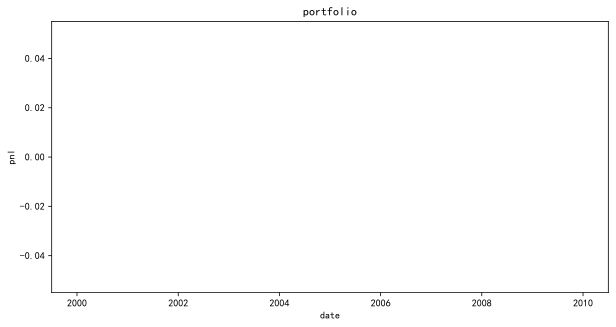

In [76]:
i = 0
strat = "gbm.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))

In [15]:
%%time
import xgboost as xgb

# xgboost regressor的固定参数
# GPU加速
ind_params = {'learning_rate': 0.1,
              "min_samples_leaf":[10,20],
              'seed':100, 
              'objective': 'reg:squarederror',
              'n_jobs':-1,
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist',
              }
              
xgb_reg = xgb.XGBRegressor(**ind_params)

# 面板搜索的参数（是一个list，不是模型的参数，注意区分）
cv_params = {'max_depth': [3,4,5,6,7,8,9,10], 
             'n_estimators': np.arange(10,200,10)}

# 并行计算cross validation（不是模型）
xgb_cv = GridSearchCV(xgb_reg, 
                        cv_params, 
                        cv = 5, n_jobs=-1) 
xgb_cv.fit(x_train, y_train)

[22:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Wall time: 25min 7s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    min_samples_leaf=[10, 20], missing=nan,
                                    mon...100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scal

In [16]:
#best_parameters, score, _ = max(xgb_cv.grid_scorer, key=lambda x: x[1])
xgb_cv.best_params_

{'max_depth': 3, 'n_estimators': 40}

In [19]:
strat = "xgb.002.4096"
signal_name = strat

In [18]:
print('XGBoost regression...')
print('Best Params:')
print(xgb_cv.best_params_)
print('Best CV Score:')
print(xgb_cv.best_score_)
save(xgb_cv, HEAD_PATH+"\\processed_data\\xgb.002.4096.pkl")

XGBoost regression...
Best Params:
{'max_depth': 3, 'n_estimators': 40}
Best CV Score:
-0.00015512104031425444


In [16]:
xgb_cv = load(HEAD_PATH+"\\processed_data\\xgb.002.4096.pkl")

In [20]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [21]:
%%time
# 这段代码极其难跑，要发掘一下原因！如果先fit了xgb，再跑这段代码就会爆出“[WinError 1455] 页面文件太小，无法完成操作”的错误，网上查说是因为内存又不够了，我TM？什么情况。
# 我现在都是先跑完xgb之后模型存储了，然后重新打开ipynb释放内存之后再load模型跑下面的TMD
# 32G内存怎么都没见过超过16G过？难道那16个G用不了？是因为conda下载的时候使用的就只能是主机的16G内存吗？还是说我应该更改什么缓存地址从C盘搞到D盘？我不理解啊。
# 而且xgb的代码如果是用gpu跑的话，竟然跑到了45min爆了个memoryerror，是因为GPU的4个G的显存用完了吗？？而且为什么用GPU反而更慢？并行都只用25min！
# 真的不理解，这个电脑的内存究竟出了什么问题，以至于一个树模型都跑不了？或者连这个5min的parLapply都跑不了？我不理解啊，是加装内存的问题吗？还有GPU是个什么情况？
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=xgb_cv, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, train_std=np.array(train_std_mat[product][:n_signal]))

Wall time: 5min 21s


In [22]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 8.68 s


In [23]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("xgb.002", np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 50s


rb train sharpe  1.148297635177163 test sharpe  0.3828818213336004
hc train sharpe  1.239211222338061 test sharpe  1.0880700588742038
i train sharpe  nan test sharpe  nan
j train sharpe  0.4197782485438399 test sharpe  -0.8189461086366651
jm train sharpe  1.354017438414298 test sharpe  0.31298478985498807
train sharpe:  nan test sharpe:  nan


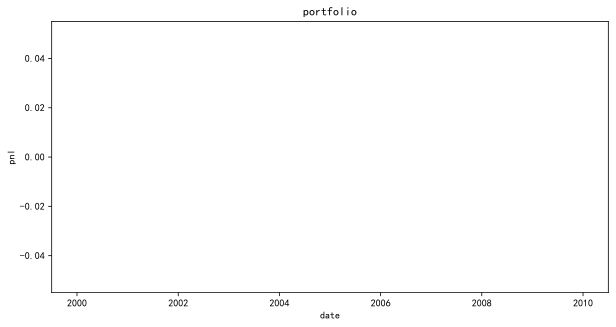

In [24]:
i = 0
strat = "xgb.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))